### Exercise 2  Handwriting recognition with MLP

Like last week's lab , your task in this section is also about recognizing handwritten digits, but you are required to use MLP to complete the exercise. It is recommended that you define an MLP class, which is a subclass of `nn.module`.

<font color='red' size=4>Note that your accuracy in this section will directly determine your score.</font>

For this exercise we use the `minist` dataset.

+ load datasets

In [1]:
########### Write Your Code Here ###########
import torchvision
from torch.utils.data import DataLoader
train_data, test_data = [torchvision.datasets.MNIST(
    root = './datasets/',  
    train = trainOrNot,       
    transform = torchvision.transforms.ToTensor(),   
    download=True
) for trainOrNot  in [True, False]]
train_loader, test_loader = [DataLoader(data, batch_size=64, shuffle=False) for data in [train_data, test_data]]
############################################                      

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


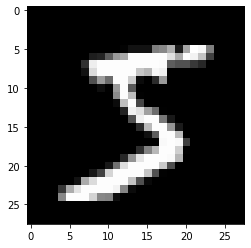

In [2]:
train_data.train_data
test_data.test_data
# train_data, test_data
trainfeature, trainlabel = next(iter(train_data))
from matplotlib import pyplot as plt
plt.imshow(trainfeature[0].detach().numpy(), cmap='gray')

+ Define a MLP subclass of nn. Module

In [3]:
########### Write Your Code Here ###########
from torch import nn
import torch
import copy
class ShareBottom(nn.Module):
    """
    MMoE
    多任务：10个数字是10个任务，独立去预测概率。最后概率最高的是答案。loss计算时用softmax+cross_entropy_loss，也可以不用。
    多专家：4x4个专家，分管7x7的区域，做一个粗陋的卷积。
    多门控
    ShareBottom
    Args:
        nn (_type_): _description_
    """
    def __init__(self) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2), # kernel_size, stride
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2)
        )
        fc = nn.Sequential(
            nn.Linear(16*4*4, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 1)
        )
        self.towers = nn.ModuleList([copy.deepcopy(fc) for _ in range(10)])
    def forward(self, img):
        feature = self.conv(img)
        feature = feature.view(img.shape[0], -1)
        out  = [tower(feature) for tower in self.towers]
        return torch.cat(out, dim=1)
        
test_model = ShareBottom()
test_X = torch.randn(1, 28, 28)
test_y = test_model(test_X)
test_y
############################################

tensor([[0.3028, 0.3028, 0.3028, 0.3028, 0.3028, 0.3028, 0.3028, 0.3028, 0.3028,
         0.3028]], grad_fn=<CatBackward0>)

+ Create the model

In [6]:
########### Write Your Code Here ###########
mlp_clf = ShareBottom()
mlp_clf
############################################

ShareBottom(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (towers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=120, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=84, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=120, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=84, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=120, bias=True)
      (1): Sigmoi

In [ ]:
list(mlp_clf.parameters())

In [7]:
for X, y in test_loader:
    print(X.shape)
    print(y.shape)
    break
test_data.test_data.data.shape
test_data.test_data.data.reshape(10000, 1, 28, 28).shape


torch.Size([64, 1, 28, 28])
torch.Size([64])


d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 1, 28, 28])

 + Loss function

In [8]:
########### Write Your Code Here ###########
criteria = nn.CrossEntropyLoss()
############################################

+ The optimizer

In [9]:
########### Write Your Code Here ###########
import torch.optim as optim
optimizer = optim.Adam(mlp_clf.parameters(), lr=0.01)
############################################

+ training Model

In [12]:
########### Write Your Code Here ###########
def train_data_loader(model, data_loader, optimizer, criteria, epochs=101):
    model.train()
    for epoch in range(epochs):
        for X, y in data_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criteria(y_pred, y)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f"epoch {epoch}, loss {loss.item()}")
train_data_loader(mlp_clf, train_loader, optimizer, criteria) #明智的选择是定义函数，而不是每次都写一遍
############################################
# 训练时间较长，后面我们存到了文件，可以直接加载

epoch 0, loss 0.10692787915468216


KeyboardInterrupt: 

In [ ]:
########### Write Your Code Here ###########
def meta_balance_train(model, data_loader, optimizer, prob_onehot_loss, epochs=101):
    model.train()
    for epoch in range(epochs):
        for X, y in data_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            y_prob = torch.softmax(y_pred, dim=1)
            y_onehot = torch.zeros_like(y_prob)
            y_onehot[:, y] = 1
            losses = [prob_onehot_loss(y_prob[:, i], y_onehot) for i in range(10)]
            def grad_norm(mod):
                grad = [p.grad.flatten() for p in mod.parameters() if p.grad is not None]
                c = torch.cat(grad)
                return torch.norm(c)
            # 不妨设主任务为0。
            losses[0].backward()
            G0 = grad_norm(model.conv)
            for loss in losses[1:]:
                
                loss.backward()
                G = grad_norm(model.conv)
                
                
            optimizer.step()
        if epoch % 10 == 0:
            print(f"epoch {epoch}, loss {loss.item()}")
meta_balance_train(mlp_clf, train_loader, optimizer, criteria) #明智的选择是定义函数，而不是每次都写一遍
############################################
# 训练时间较长，后面我们存到了文件，可以直接加载

In [25]:
mlp_clf.conv.parameters()
mlp_clf.conv.zero_grad()
grad = [p.grad.flatten() for p in mlp_clf.conv.parameters()]
c = torch.cat(grad, dim=0)
c.norm()
# grad

tensor(0.)

In [31]:
a = torch.randn(2, 3, requires_grad=True)
b = a*3
b.sum().backward()
a.grad
b.sum().backward()
a.grad


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [15]:
torch.save(mlp_clf.state_dict(), "share_bottom.pth")
print("Saved PyTorch Model State to share_bottom.pth")

Saved PyTorch Model State to share_bottom.pth


In [4]:
mlp_clf = ShareBottom() # 需要时同一个类型的model
mlp_clf.load_state_dict(torch.load("share_bottom.pth"))

NameError: name 'ReallyDeepMLP' is not defined

+ Model Performance

In [13]:
########### Write Your Code Here ###########
mlp_clf.eval()
y_pred = mlp_clf(test_data.test_data.reshape(10000, 1, 28, 28).float())
criteria(y_pred, torch.tensor(test_data.test_labels))
############################################

d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
d:\EnglishStandardPath\DevProgramsFile\Python\python39\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
C:\Users\YeCanming\AppData\Local\Temp\ipykernel_30484\3406663984.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  criteria(y_pred, torch.tensor(test_data.test_labels))


tensor(0.2657, grad_fn=<NllLossBackward0>)

In [130]:
y_pred.shape
# y_pred[0]
# torch.argmax(y_pred, axis=1)

torch.Size([10000, 10])

ShareBottom accuracy = 0.9232
fper=[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.10864745e-04
 1.10864745e-04 2.21729490e-04 2.21729490e-04 3.32594235e-04
 3.32594235e-04 4.43458980e-04 4.43458980e-04 5.54323725e-04
 5.54323725e-04 6.65188470e-04 6.65188470e-04 8.86917960e-04
 8.86917960e-04 9.97782705e-04 9.97782705e-04 1.33037694e-03
 1.33037694e-03 1.44124169e-03 1.44124169e-03 1.55210643e-03
 1.55210643e-03 1.77383592e-03 1.77383592e-03 2.21729490e-03
 2.21729490e-03 2.32815965e-03 2.32815965e-03 2.43902439e-03
 2.43902439e-03 3.10421286e-03 3.10421286e-03 3.54767184e-03
 3.54767184e-03 3.76940133e-03 3.76940133e-03 3.88026608e-03
 3.88026608e-03 3.99113082e-03 3.99113082e-03 4.43458980e-03
 4.43458980e-03 4.65631929e-03 4.65631929e-03 4.87804878e-03
 4.87804878e-03 4.98891353e-03 4.98891353e-03 5.09977827e-03
 5.09977827e-03 5.21064302e-03 5.21064302e-03 5.65410200e-03
 5.65410200e-03 6.20842572e-03 6.20842572e-03 6.43015521e-03
 6.43015521e-03 8.53658537e-03 8.53658537e-03 8.75

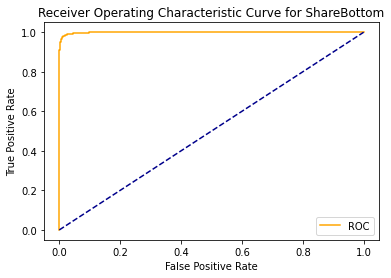

In [14]:
from fast_evaluation import *
evaluate_multiclass2(mlp_clf, y_pred.detach().numpy(), test_data.test_labels.detach().numpy())
# 可见，测试集准确率达到96.59%。对0的分类的ROC曲线可以画出来：

### Exercise 3  Questions (10 points )
1.What's the difference between logistic regression and Perceptron?

2.Advantages and disadvantages of neural networks?

3.What is the role of Activation Function in Neural networks?